# Imports and params

In [1]:
!pip install -qq transformers

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

fig_size = (10, 6)
sns.set(rc={'figure.figsize':fig_size})
RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!nvidia-smi

Sat Mar 20 09:00:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Look at the Data and choose a set to train on

In [6]:
run_name = 'arxiv_181920'
df = pd.read_csv(f'gdrive/MyDrive/Colab/SentimentTutorial/{run_name}.csv')
df.shape

(21000, 6)

In [42]:
categories=list(df.category.unique())
categories

['astro-ph',
 'cond-mat',
 'cs',
 'gr-qc',
 'hep-ex',
 'hep-ph',
 'hep-th',
 'math',
 'math-ph',
 'nlin',
 'nucl-th',
 'physics',
 'q-bio',
 'quant-ph']

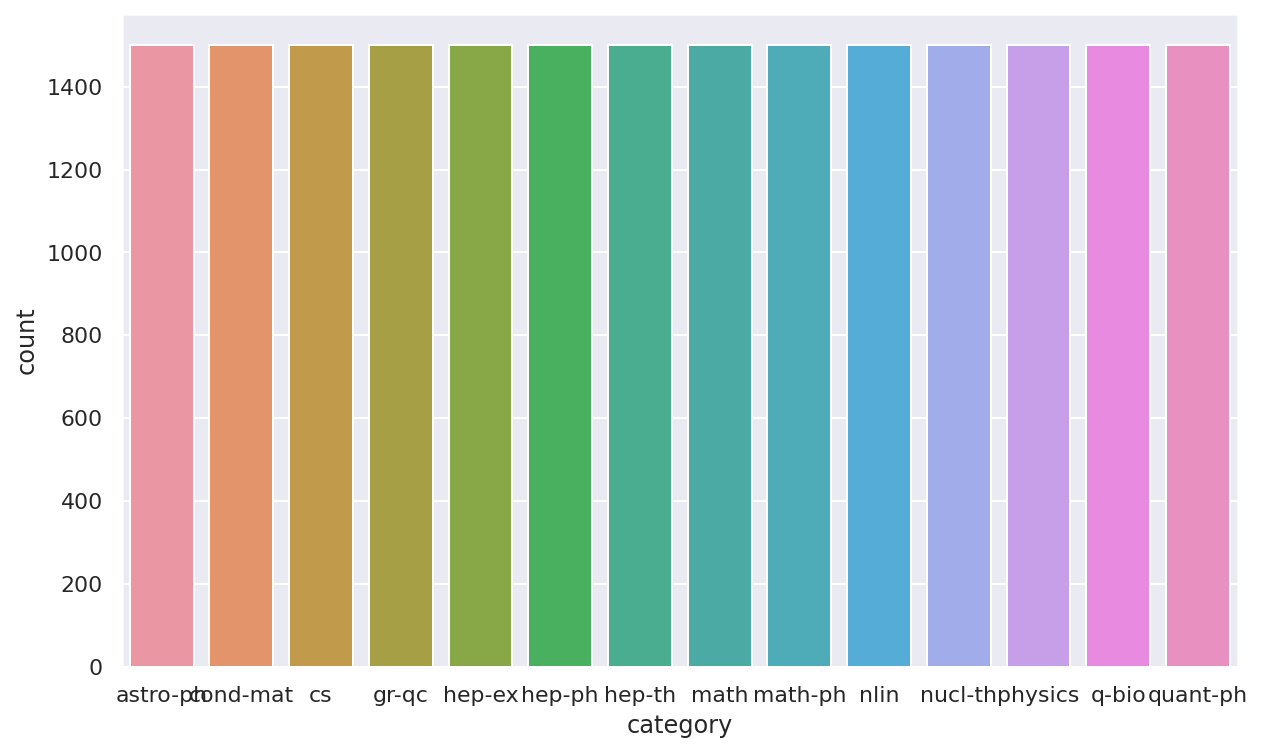

In [8]:
sns.countplot(x=df.category)
plt.xlabel('category');

## Load up BERT tools to tokenize abstracts

In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [10]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

## Tokenize the abstracts and choose a max number of tokens that catches most everything

In [11]:
token_lens = []

for txt in df.abstract:
  tokens = tokenizer.encode(txt, max_length=600, truncation=True)
  token_lens.append(len(tokens))

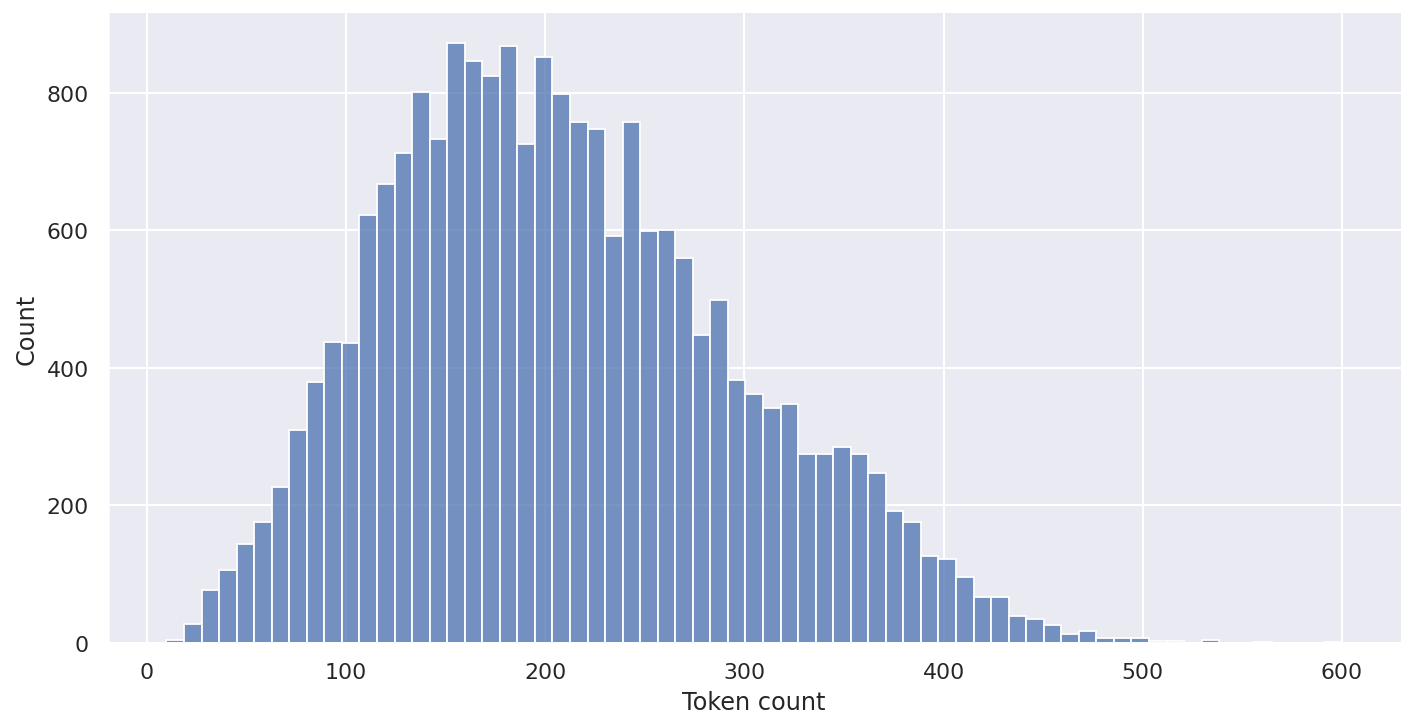

In [12]:
sns.displot(x=token_lens, aspect=2)
plt.xlabel('Token count');

In [13]:
MAX_LEN = 450

In [14]:
test = [ x > MAX_LEN for x in token_lens]
print(f'cut {sum(test)/len(test)} percent of abstracts short')

cut 0.004095238095238095 percent of abstracts short


In [15]:
TEST_SIZE = .1

strat_targets = df.cat_int
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=strat_targets)

strat_targets2 = df_test.cat_int
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED, stratify=strat_targets2)

df_train.shape, df_val.shape, df_test.shape

((18900, 6), (1050, 6), (1050, 6))

[Text(0, 0.5, ''), Text(0.5, 0, '')]

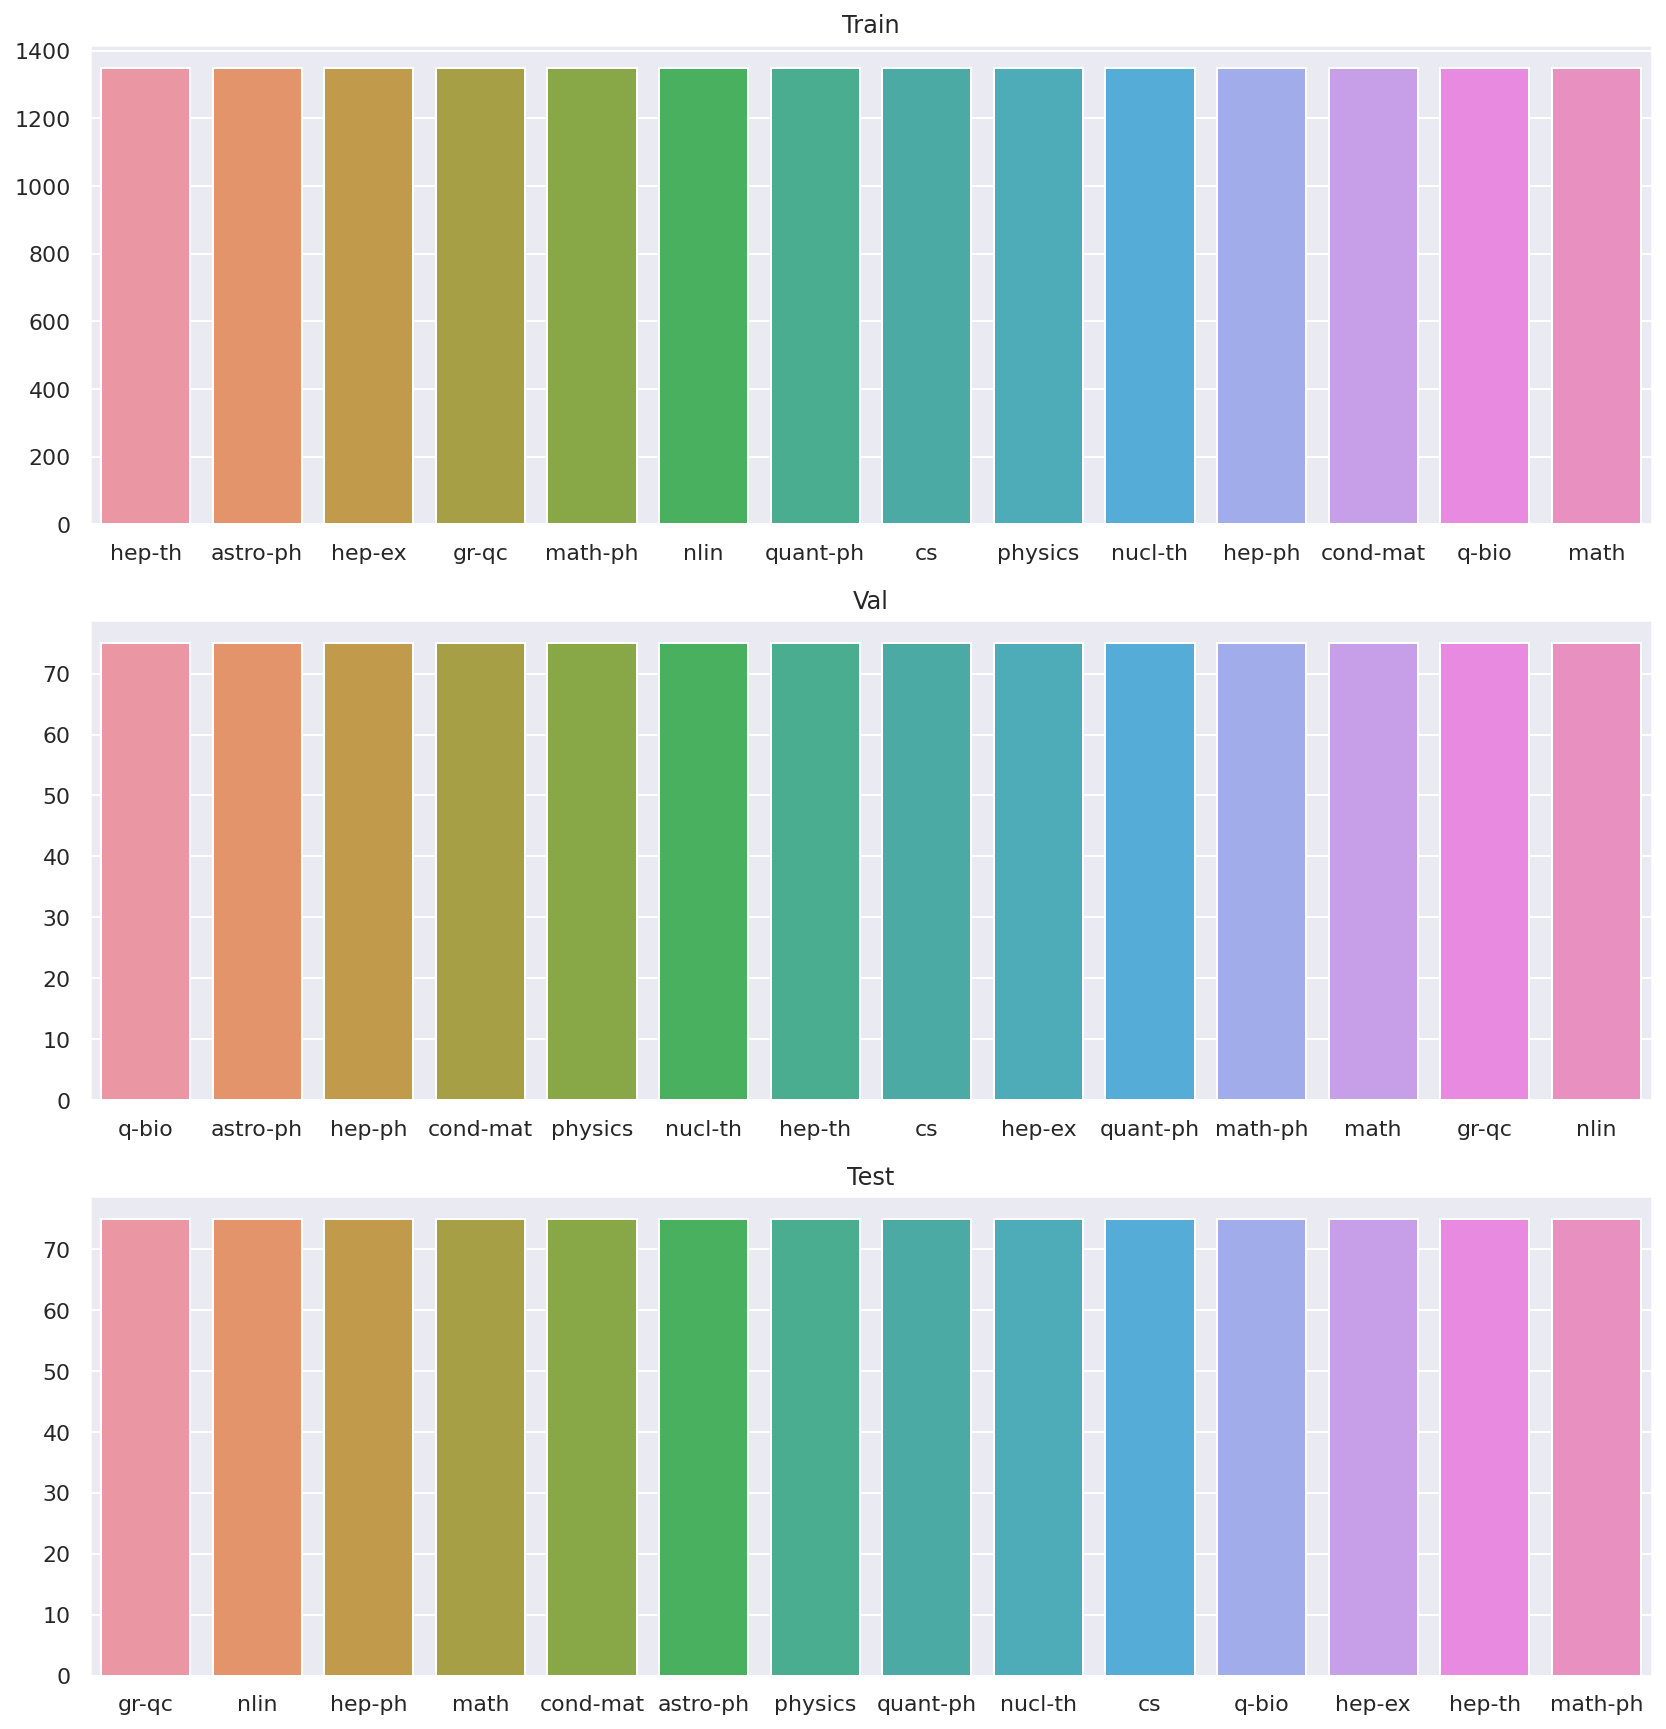

In [16]:
fig, ax = plt.subplots(3, figsize=(14,15))
p1 = sns.countplot(x=df_train.category, ax=ax[0])
p1.set_title('Train')
p1.set(xlabel=None, ylabel=None)

sns.countplot(x=df_val.category, ax=ax[1])
ax[1].set_title('Val')
ax[1].set(xlabel=None, ylabel=None)

sns.countplot(x=df_test.category, ax=ax[2])
ax[2].set_title('Test')
ax[2].set(xlabel=None, ylabel=None)

# Make the PyTorch dataset and data loaders

In [17]:
class ArXivAbstractDataset(Dataset):  
  #This class gives the encoding for an abstract selected via "item"?

  def __init__(self, texts, xlists, targets, tokenizer, max_len): 
    self.texts = texts
    self.xlists = xlists
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text = str(self.texts[item])
    croscat = self.xlists[item]
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      truncation=True,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'abstract_text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'cross_list_cats': croscat
    }

In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ArXivAbstractDataset(
    texts=df.abstract.to_numpy(),
    xlists=df.cross_lists.to_numpy(),
    targets=df.cat_int.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [19]:
BATCH_SIZE = 10

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['abstract_text', 'input_ids', 'attention_mask', 'targets', 'cross_list_cats'])

In [21]:
print(data['input_ids'].shape)  #BATCH_SIZE by MAX_LEN tokens per item
print(data['attention_mask'].shape)
print(data['targets'].shape) #BATCH_SIZE (just targets)

torch.Size([10, 450])
torch.Size([10, 450])
torch.Size([10])


## Make the model and put it on the GPU

In [22]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [23]:
DROPOUT = 0.5

class CategoryClassifier(nn.Module):

  def __init__(self, n_classes):
    super(CategoryClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=DROPOUT)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [24]:
model = CategoryClassifier(len(categories))
model = model.to(device)

In [25]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([10, 450])
torch.Size([10, 450])


Apply a softmax function

In [26]:
F.softmax(model(input_ids, attention_mask), dim=1) 

tensor([[0.0521, 0.1243, 0.1189, 0.1308, 0.0412, 0.0388, 0.0659, 0.0274, 0.1210,
         0.0521, 0.0604, 0.0590, 0.0498, 0.0584],
        [0.1574, 0.0661, 0.1058, 0.0364, 0.0464, 0.0331, 0.0457, 0.0608, 0.0962,
         0.0397, 0.1550, 0.0505, 0.0465, 0.0604],
        [0.0515, 0.0976, 0.1817, 0.0711, 0.0379, 0.0691, 0.0274, 0.0473, 0.0866,
         0.0675, 0.0816, 0.1178, 0.0302, 0.0327],
        [0.0800, 0.1625, 0.0835, 0.0381, 0.0432, 0.0376, 0.0217, 0.0462, 0.2015,
         0.0738, 0.0415, 0.0978, 0.0330, 0.0395],
        [0.0387, 0.0802, 0.1749, 0.0504, 0.0396, 0.0197, 0.0586, 0.0518, 0.0706,
         0.0599, 0.0807, 0.1361, 0.0730, 0.0659],
        [0.0468, 0.1387, 0.1663, 0.0585, 0.0358, 0.0325, 0.0350, 0.0335, 0.1243,
         0.0704, 0.0626, 0.0617, 0.0328, 0.1012],
        [0.1288, 0.1390, 0.1004, 0.0649, 0.0688, 0.0938, 0.0196, 0.0397, 0.0869,
         0.0786, 0.0376, 0.0540, 0.0276, 0.0602],
        [0.0542, 0.1984, 0.0829, 0.0259, 0.0887, 0.0184, 0.0628, 0.0414, 0.0872,
  

# Training (Feel free to skip this and download the appropriate model in the next section)

In [27]:
EPOCHS = 10
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [28]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [29]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [30]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,      
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)  
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )
  if epoch == 0: val_loss0 = val_loss

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
  if (epoch > 3 and val_loss > 1.3 * val_loss0 ):
    print('Overfitting')
    break

Epoch 1/10
----------
Train loss 1.0375994268036077 accuracy 0.6611111111111111
Val   loss 0.7634410612639927 accuracy 0.7476190476190476

Epoch 2/10
----------
Train loss 0.5683390370782011 accuracy 0.816931216931217
Val   loss 0.7597126684018544 accuracy 0.7561904761904762

Epoch 3/10
----------
Train loss 0.36796364249765046 accuracy 0.8866137566137566
Val   loss 0.9804741412401199 accuracy 0.7552380952380953

Epoch 4/10
----------
Train loss 0.24703940329580473 accuracy 0.9310582010582011
Val   loss 1.1479734172512377 accuracy 0.7571428571428571

Epoch 5/10
----------
Train loss 0.17168197255487994 accuracy 0.9571957671957673
Val   loss 1.2945875335739747 accuracy 0.7704761904761904

Overfitting
CPU times: user 25min 59s, sys: 18min 31s, total: 44min 30s
Wall time: 45min 44s


In [31]:
path = f'gdrive/MyDrive/Colab/SentimentTutorial/best_model_state_{run_name}.bin'
torch.save(model.state_dict(), path)

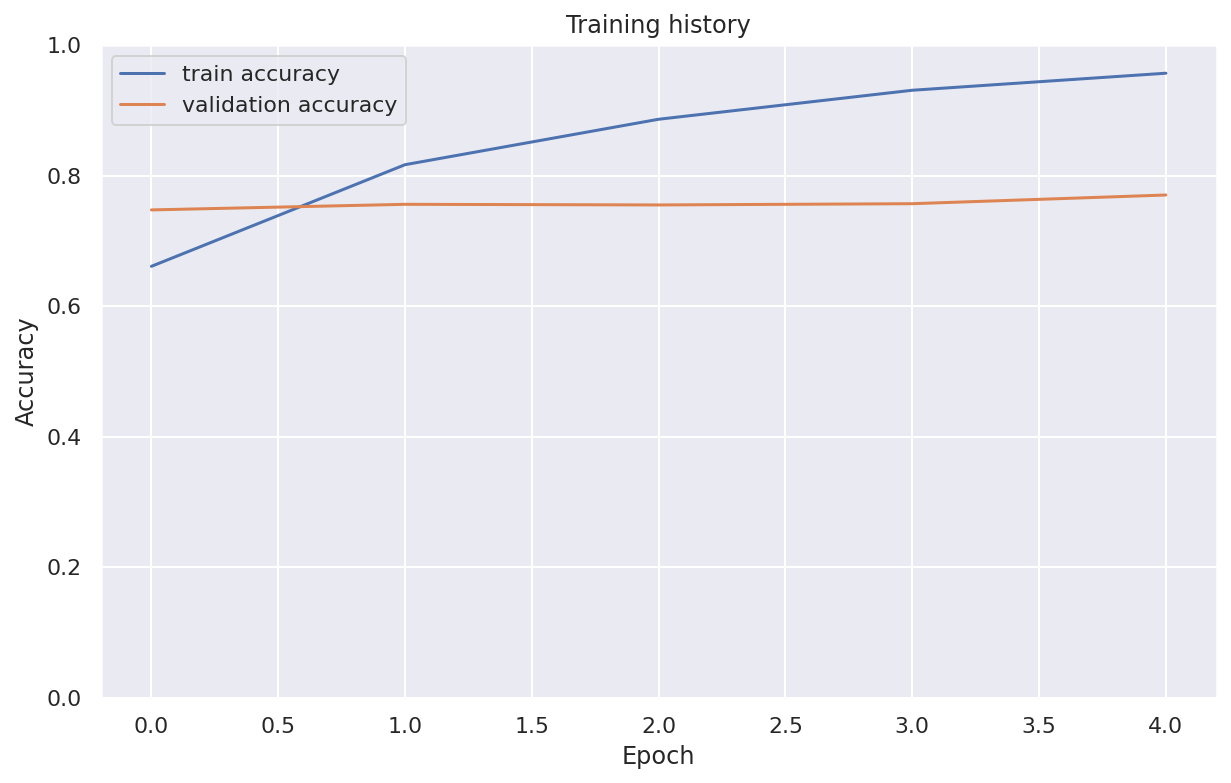

In [32]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Evaluate Model, go to Evaluation notebook for more

In [ ]:
#DOWNLOAD A MODEL OF YOUR CHOOSING
#YOUR_MODEL =f'best_model_state_{run_name}.bin'

In [33]:
model = CategoryClassifier(len(categories))
# model.load_state_dict(torch.load(f'gdrive/MyDrive/Colab/SentimentTutorial/{YOUR_MODEL}', map_location=torch.device('cpu')))
model.load_state_dict(torch.load('best_model_state.bin'))          # USE THIS IF YOU JUST TRAINED A MODEL
model = model.to(device)

### Metrics

In [34]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7714285714285715

In [35]:
def get_predictions(model, data_loader):  # get some predictions from the model
  model = model.eval()
  
  abstract_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  cross_lists = []

  with torch.no_grad():
    for d in data_loader:

      atexts = d["abstract_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      xlists = d['cross_list_cats']

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      abstract_texts.extend(atexts)
      cross_lists.extend(xlists)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return abstract_texts, predictions, prediction_probs, real_values, cross_lists

In [36]:
y_abs_texts, y_pred, y_pred_probs, y_test, y_xlists = get_predictions(
  model,
  test_data_loader
)

In [41]:
print(classification_report(y_test, y_pred, target_names=categories))

              precision    recall  f1-score   support

    astro-ph       0.81      0.72      0.76        75
    cond-mat       0.85      0.92      0.88        75
          cs       0.66      0.79      0.72        75
       gr-qc       0.55      0.63      0.58        75
      hep-ex       0.84      0.48      0.61        75
      hep-ph       0.60      0.52      0.56        75
      hep-th       0.69      0.77      0.73        75
        math       0.81      0.83      0.82        75
     math-ph       0.87      0.71      0.78        75
        nlin       0.61      0.64      0.62        75
     nucl-th       0.84      0.87      0.86        75
     physics       0.86      0.75      0.80        75
       q-bio       0.92      0.92      0.92        75
    quant-ph       0.68      0.91      0.78        75

    accuracy                           0.75      1050
   macro avg       0.76      0.75      0.74      1050
weighted avg       0.76      0.75      0.74      1050



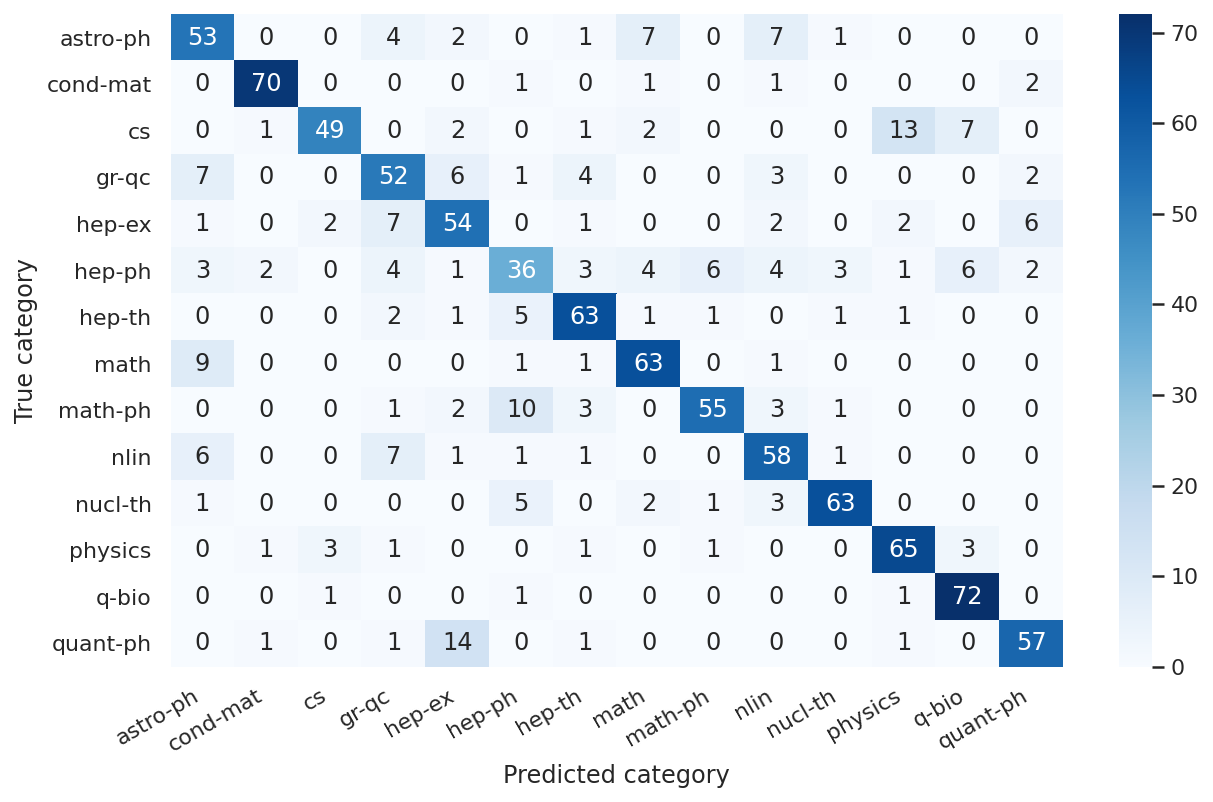

In [37]:
def show_confusion_matrix(confusion_matrix): 
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True category')
  plt.xlabel('Predicted category');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=categories, columns=categories)
show_confusion_matrix(df_cm)